In [400]:
using LinearAlgebra
using PlotlyJS
using ForwardDiff, Roots
using Random 
using Base.Threads

include("math.jl")

const Vec3 = Vector{Float64};
const Vec2 = Vector{Float64};
const Point = Vec3;
const Direction = Vec3;
const invalid_vector =[NaN, NaN, NaN]

# Define the Ray structure ===============================================================================
mutable struct Ray
    origin::Point       # 3D vector origin position
    direction::Direction # 3D vector direction
    amplitude::Float64  # Amplitude of the ray
    
    # Constructor with default amplitude value
    function Ray(origin::Point, direction::Direction; amplitude::Float64=1.0)
        new(origin, direction, amplitude)
    end
end
# ============================================================================================================

# Define the structure for light sources ===============================================================================
function isotropic_distribution()
    function sample_direction()
        θ = 2π * rand()     # Azimuthal angle (0 to 2π)
        ϕ = acos(2 * rand() - 1)  # Polar angle (cosine-weighted for uniform sphere)
        return [sin(ϕ) * cos(θ), sin(ϕ) * sin(θ), cos(ϕ)]
    end
    return () -> sample_direction()
end

function collimated_distribution(direction::Vec3)
    return () -> normalize(direction)  # Always emits in the same direction
end

function cone_distribution(main_direction::Vec3, spread_angle::Float64)
    function sample_direction()
        θ = spread_angle * sqrt(rand())  # Cone angle (scaled probability)
        ϕ = 2π * rand()  # Uniform azimuth

        # Local coordinate system
        z = normalize(main_direction)
        x = normalize(cross(z, [0, 1, 0]))  # Ensure perpendicular x
        y = cross(z, x)  # Ensure perpendicular y

        # Convert to Cartesian
        dir = cos(θ) * z + sin(θ) * (cos(ϕ) * x + sin(ϕ) * y)
        return normalize(dir)
    end
    return sample_direction
end

custom_dist = () -> normalize(randn(3))  # Gaussian-distributed emission

abstract type Source end

struct PointSource <: Source
    # define the point source structure
    center::Point # 3d vector center position
    intensity::Float64 # intensity of the light source
    distribution::Function  # Function that returns a direction
end

struct EnsembleSource <: Source
    objects::Vector{Source}
end

function emit_ray(source::Source)::Ray
    direction = source.distribution()
    return Ray(source.center, direction)
end

function emit_rays(source::Source, num_rays::Int)::Vector{Ray}
    rays = Ray[]
    for _ in 1:num_rays
        push!(rays, emit_ray(source))
    end
    return rays
end
# ==============================================================================================================

# Define the structure for surfaces  ===============================================================================
struct  Frame 
    origin:: Point
    orientation:: Matrix{Float64} # a 3x3 rotation matrix that transform the lab frame to the object frame
    
end

abstract type Surface end

struct ImplicitSurface <: Surface 
    # define the surface structure
    frame:: Frame # the frame of the surface
    shape:: Function # bound functions specifying the 3d shape, f(x, y, z)=0
    bounds:: Vector{Tuple{Float64, Float64}}
    border:: Function # bound functions specifying the boundary line
end

function shape_plane(center::Vec3)
    return (p) -> p[3] - center[3]
end


# example shape function: Define a spherical surface as the shape function
function shape_sphere(center::Vec3, radius::Float64)
    return (p) -> (p - center)⋅(p - center) - radius^2  # Sphere equation: ||p - center|| = radius
end

function shape_hemisphere(center::Vec3, radius::Float64)
    function result(p)
        incap = radius^2-(p[1] - center[1])^2-(p[2] - center[2])^2
        return incap < 0 ? NaN : (p[3]- center[3]) - sqrt(incap) 
    end
    return (p) -> result(p)
end

# Define a paraboloid shape function
# function shape_paraboloid(center::Vec3, f::Float64)
#     return (p::Vec3) -> (p[3]- center[3]) - ((p[1]- center[1])^2 + (p[2]- center[2])^2) / (4 * f)  # Paraboloid equation: z = (x^2 + y^2) / (4f)
# end

function shape_paraboloid(center::Vec3, f::Float64)
    return (p) -> (p[3]- center[3]) - ((p[1]- center[1])^2 + (p[2]- center[2])^2) / (4 * f)  # Paraboloid equation: z = (x^2 + y^2) / (4f)
end

function shape_mexican_hat(center::Vec3, A::Float64, B::Float64, C::Float64)
    return (p) -> (p[3] - center[3]) - A * (1 - ((p[1] - center[1])^2 + (p[2] - center[2])^2) / B^2) * exp(-((p[1] - center[1])^2 + (p[2] - center[2])^2) / (2 * C^2))
end


function shape_coneflat(center::Vec3, height::Float64, radius::Float64, angle::Float64)
    function result(p)
        x, y, z = p .- center  # Shift coordinates relative to the center
        radial_dist = sqrt(x^2 + y^2)
        r_top = radius
        r_bottom = radius + height * tan(angle)

        if radial_dist <= radius
            return z-height  # Outside the top
        elseif radial_dist <= r_bottom
            return  z-height+(radial_dist-radius)/tan(angle) # Conical region
        else
            return z  # Flat bottom outside cone
        end
    end
    return (p) -> result(p)
end

function border_circle(radius::Float64)
    return (p) -> p⋅p - radius^2  # Circle equation: ||p - center|| = radius
end

function border_outcircle(radius::Float64)
    return (p) -> -p⋅p + radius^2  # Circle equation: ||p - center|| = radius
end

function border_bounds()
    return (p) -> -1  #  bound line for surface is defined by bounds
end

function surface_normal(p, surface::Surface)

    # Calculate the gradient of the surface shape function
    grad_S = ForwardDiff.gradient(surface.shape, p)
    
    # Normalize the gradient to get the normal
    return grad_S ./ norm(grad_S)
end

function draw_surface(surface:: Surface, nx::Int=100, ny::Int=100, color="random", display::Bool=false)
    # plot the surface
    xarray = range(surface.bounds[1][1], stop=surface.bounds[1][2], length=nx)
    yarray = range(surface.bounds[2][1], stop=surface.bounds[2][2], length=ny)
    xmesh = zeros(nx, ny)
    ymesh = zeros(nx, ny)
    zmesh = zeros(nx, ny)
    for ii in 1:1:nx, jj in 1:1:ny
    
        bounded = surface.border([xarray[ii], yarray[jj]]) < 0
        xval = xarray[ii]
        yval = yarray[jj]
        zval = bounded ? -surface.shape([xarray[ii], yarray[jj], 0.0]) : NaN

        xval, yval, zval = surface.frame.orientation * [xval, yval, zval]
        xmesh[ii, jj] = xval + surface.frame.origin[1]
        ymesh[ii, jj] = yval + surface.frame.origin[2]
        zmesh[ii, jj] = zval + surface.frame.origin[3]
    end
    # Generate a random color (RGB format)
    if color=="random"
        color = string("rgb(", round(255 * rand()), ",", round(255 * rand()), ",", round(255 *  rand()), ")")
    end;

    surface_data = PlotlyJS.surface(
        x=xmesh,
        y=ymesh,
        z=zmesh,
        surfacecolor=zmesh*0.0,
        colorscale=[(0, color), (1, color)],  # Fix the color scale to the same random color
        shading="smooth",  # Smoothing the shading on the surface
        showscale=false,
        opacity=0.8
        )

    if display

        layout = Layout(
            title="Surface Plot",
            width=800,   # Set width in pixels
            height=600,  # Set height in pixels
            scene=attr(
                xaxis=attr(visible=false, showgrid=false, zeroline=false),
                yaxis=attr(visible=false, showgrid=false, zeroline=false),
                zaxis=attr(visible=false, showgrid=false, zeroline=false),
                bgcolor="rgba(0,0,0,0)",  # Transparent background
                aspectmode="data"
            ),
            paper_bgcolor="rgba(0,0,0,0)",  # Transparent outer background
            showlegend=false
        )
        # Display the plot
        fig = plot([surface_data] , layout);
        display(fig)   
        return NaN  
    end
    return [surface_data]
end

function draw_snormals(surface:: Surface, num:: Int,  ray_length::Float64=0.5, arrow_scale::Float64=0.3, color="random")
    xarray = range(surface.bounds[1][1], stop=surface.bounds[1][2], length=nx)
    yarray = range(surface.bounds[2][1], stop=surface.bounds[2][2], length=ny)

    rays_snorm = Ray[]
    for ii in 1:1:num
        bounded = false
        while ~bounded
            xx = rand(surface.bounds[1][1]:surface.bounds[1][2])
            yy = rand(surface.bounds[2][1]:surface.bounds[2][2])
            bounded = surface.border([xx, yy]) < 0
        end
        zz = -surface.shape([xx,yy,0.0])
        snorm = surface_normal([xx, yy, zz], surface)
        snorm = surface.frame.orientation * snorm
        xx, yy, zz = surface.frame.orientation * [xx, yy, zz] + surface.frame.origin
        push!(rays_snorm, Ray([xx, yy, zz], snorm))
    end
    return draw_rays(rays_snorm, ray_length, arrow_scale, color)
end

# Function to generate and plot rays with arrows
function draw_rays(rays::Vector{Ray}, ray_length::Float64=0.5, arrow_scale::Float64=0.3, color::String="random")
    traces = GenericTrace[]

    color = color == "random" ? "rgb($(rand(0:255)), $(rand(0:255)), $(rand(0:255)))" : color
    # Line traces for the rays
    for ray in rays
        start = ray.origin
        stop = start + normalize(ray.direction) * ray_length
        trace_rays = scatter3d(
            x=[start[1], stop[1]], y=[start[2], stop[2]], z=[start[3], stop[3]],
            mode="lines",
            line=attr(color=color,width=3)
        )
        push!(traces, trace_rays)
    end

    # Arrow traces using cones
    origins = hcat([ray.origin + normalize(ray.direction) * ray_length for ray in rays]...)  # Arrow positions
    directions = hcat([normalize(ray.direction) for ray in rays]...)  # Arrow directions
    if length(origins) > 0
        trace_arrows = cone(
            x=origins[1, :], y=origins[2, :], z=origins[3, :],  # Positions
            u=directions[1, :], v=directions[2, :], w=directions[3, :],  # Directions
            sizemode="raw",
            sizeref=arrow_scale,  # Controls arrow size
            anchor="tail",
            showscale=false,
            colorscale=[(0, color), (1, color)],
            opacity=0.8
        )
        push!(traces, trace_arrows)
    end

    return traces
end
# ==============================================================================================================


#  Define the structure for material and objects ==========================================================================
abstract type Material end

struct Dielectric <: Material
    n:: Float64
end

struct Metal <: Material
    fuzz:: Float64
    albedo:: Vec3
end

abstract type Object end # object that can be hit by rays
struct BoundObject <: Object
    frame:: Frame # the frame of the object
    surfaces:: Vector{Surface}
    material:: Material
    bounds:: Vector{Tuple{Float64, Float64}}
end

struct Sheet <: Object
    frame:: Frame # the frame of the object
    surfaces:: Vector{Surface}
    material:: Material
end

struct Blocker <: Object
    frame:: Frame # the frame of the object
    surfaces:: Vector{Surface}
end

function draw_object(
    obj::Object, 
    num_sx::Int, 
    num_sy::Int, 
    num_sn::Int,
    ;
    drawnormals::Bool=true, 
    arrow_scale::Float64=1.0,
    color_sf::String="random", 
    color_sn::String="random",
    display::Bool=true)
    objsize = sum([upper - lower for (lower, upper) in obj.bounds])/3.0
    arrsize = objsize/20.0*arrow_scale
    color_sf = color_sf == "random" ? "rgb($(rand(0:255)), $(rand(0:255)), $(rand(0:255)))" : color_sf
    color_sn = color_sn == "random" ? "rgb($(rand(0:255)), $(rand(0:255)), $(rand(0:255)))" : color_sn
    plottraces = GenericTrace[]
    for ss in obj.surfaces
        # rotate and shift the surface by the object's coordinates first
        frame_sf_lab = Frame(obj.frame.origin+ss.frame.origin, obj.frame.orientation*ss.frame.orientation)
        ss_tolab = ImplicitSurface(
            frame_sf_lab, 
            ss.shape, 
            ss.bounds, 
            ss.border
        ) # only work ImplicitSurface for now TODO: generalize it

        append!(plottraces, vcat(
            draw_surface(ss_tolab, num_sx, num_sy, color_sf), 
            draw_snormals(ss_tolab, num_sn, 0.5*arrsize, 0.3*arrsize, color_sn)
            )) 
    end

    if display
        layout = PlotlyJS.Layout(
        title="Box Surface Plot",
        width=800,   # Set width in pixels
        height=600,  # Set height in pixels
        scene=attr(
            xaxis=attr(visible=false, showgrid=false, zeroline=false),
            yaxis=attr(visible=false, showgrid=false, zeroline=false),
            zaxis=attr(visible=false, showgrid=false, zeroline=false),
            bgcolor="rgba(0,0,0,0)",  # Transparent background
            aspectmode="data"
        ),
        paper_bgcolor="rgba(0,0,0,0)",  # Transparent outer background
        showlegend=false
        )
        
        # Display the plot
        fig = PlotlyJS.plot(plottraces , layout);
        PlotlyJS.display(fig)   
        return NaN
    else
        return plottraces
    end
end
# ================================================================================================================

draw_object (generic function with 1 method)

In [147]:
focal_length = 2.0  # Focal length of the paraboloid
hem_radius = 4.0  # Radius of the hemispherical boundary
bound_radius = 4.5
x_range = (-5.0, 5.0)  # X range
y_range = (-5.0, 5.0)  # Y range
nx = 50 # number of points along x
ny = 50 # number of points along y
num_sn = 100 # number of surface normals
identity_matrix = rotation_matrix([0.0, 0.0, 1.0], 0.0) 
rotx_matrix = rotation_matrix([1.0, 0.0, 0.0], π/4.0) 
roty45_matrix = rotation_matrix([0.0, 1.0, 0.0], -π/4.0) 
flip_matrix = rotation_matrix([1.0, 0.0, 0.0], π*1.0) 

labframe = Frame([0.0,10.0,0.0], identity_matrix)
objframe = Frame([10.0,0.0,0.0], rotx_matrix)
objframe2 = Frame([0.0,-5.0,0.0], roty45_matrix)
objframe3 = Frame([0.0,-5.0,0.0], flip_matrix)
bounds = [x_range, y_range]

parasurface = ImplicitSurface(
    labframe, 
    shape_paraboloid([0.0, 0.0, 0.0], focal_length), 
    bounds,
    border_circle(bound_radius))

    
parasurface = ImplicitSurface(
    labframe, 
    shape_paraboloid([0.0, 0.0, 0.0], focal_length), 
    bounds,
    border_circle(bound_radius))
    
hemisurface = ImplicitSurface(
    objframe, 
    # shape_paraboloid([0.0, 0.0, 0.0], focal_length), 
    shape_hemisphere([0.0, 0.0, 0.0], hem_radius), 
    bounds,
    border_circle(bound_radius))

coneflatsurface = ImplicitSurface(
    objframe2,
    shape_coneflat([0.0, 0.0, -5.0], 4.0, 2.0, π/180*30),
    bounds,
    border_bounds()
    # border_circle([0.0, 0.0], bound_radius)
    )

flatsurfarce1 = ImplicitSurface(
    objframe2, 
    # objframe,
    shape_plane([0.0, 0.0, 5.0]),
    bounds,
    border_bounds()
    # border_circle([0.0, 0.0], bound_radius)
    )

mhatsurface = ImplicitSurface(
    objframe3, 
    shape_mexican_hat([0.0, 0.0, 10.0], 4.0, 1.0, 1.0),
    bounds,
    border_bounds())


# # plot the surfaces using plotly--------
# plottraces = vcat(
#     draw_surface(parasurface, nx, ny),
#     draw_snormals(parasurface, num_sn),
#     draw_surface(hemisurface, nx, ny),
#     draw_snormals(hemisurface, num_sn),
#     draw_surface(coneflatsurface, nx, ny),
#     draw_snormals(coneflatsurface, num_sn),
#     draw_surface(flatsurfarce1, nx, ny),
#     draw_snormals(flatsurfarce1, num_sn),
#     draw_surface(mhatsurface, nx, ny),
#     draw_snormals(mhatsurface, num_sn)
# )


# layout = Layout(
#     title="Surface Plot",
#     width=800,   # Set width in pixels
#     height=600,  # Set height in pixels
#     scene=attr(
#         xaxis=attr(visible=false, showgrid=false, zeroline=false),
#         yaxis=attr(visible=false, showgrid=false, zeroline=false),
#         zaxis=attr(visible=false, showgrid=false, zeroline=false),
#         bgcolor="rgba(0,0,0,0)",  # Transparent background
#         aspectmode="data"
#     ),
#     paper_bgcolor="rgba(0,0,0,0)",  # Transparent outer background
#     showlegend=false
# )

# # Display the plot
# fig = plot(plottraces , layout);
# display(fig)

ImplicitSurface(Frame([0.0, -5.0, 0.0], [1.0 0.0 0.0; 0.0 -1.0 -1.2246467991473532e-16; 0.0 1.2246467991473532e-16 -1.0]), var"#321#322"{Vector{Float64}, Float64, Float64, Float64}([0.0, 0.0, 10.0], 4.0, 1.0, 1.0), [(-5.0, 5.0), (-5.0, 5.0)], var"#328#329"())

In [212]:
mutable struct TrajectoryNode
    ray::Ray
    children::Vector{TrajectoryNode}
end

mutable struct Trajectory
    root::TrajectoryNode
end

function add_child!(parent::TrajectoryNode, child::Ray)
    push!(parent.children, TrajectoryNode(child, []))
end

# Function to extract ray segments for plotting
function extract_ray_segments(node::TrajectoryNode, segments::Vector{Tuple{Point, Point, Float64}})
    ray = node.ray
    if !isempty(node.children)
        # Use the origin of the first child as the endpoint
        endpoint = node.children[1].ray.origin
        push!(segments, (ray.origin, endpoint, ray.amplitude))
        for child in node.children
            extract_ray_segments(child, segments)
        end
    end
end

# Function to normalize amplitudes to [0,1] for opacity scaling
function normalize_amplitudes(segments)
    if length(segments) == 0
        return segments
    else
        max_amp = maximum(abs(seg[3]) for seg in segments)
        min_amp = minimum(abs(seg[3]) for seg in segments)
        return [(seg[1], seg[2], (seg[3] - min_amp) / (max_amp - min_amp + 1e-6)) for seg in segments]
    end
end

function set_opacity_in_rgba(rgba_string::String, opacity::Float64)
    # Remove "rgba()" and split the string by commas
    rgb_values = match(r"rgba\((\d+),\s*(\d+),\s*(\d+),\s*(\d*\.?\d+)\)", rgba_string).captures

    # Extract RGB values and convert to integers
    r = parse(Int, rgb_values[1])
    g = parse(Int, rgb_values[2])
    b = parse(Int, rgb_values[3])

    # Construct the new RGBA string with user-defined opacity
    new_rgba = "rgba($r, $g, $b, $opacity)"
    
    return new_rgba
end

# Function to convert amplitude to RGBA color (blue with variable opacity)
function amplitude_to_rgba(amplitude::Float64; color::String="rgba(255, 255, 0, 1)")
    min_opacity = 0.1  # Minimum visibility
    max_opacity = 1.0  # Fully visible
    alpha = min_opacity + (max_opacity - min_opacity) * amplitude
    return set_opacity_in_rgba(color, alpha)
end

# Function to plot the trajectory using Plotly
function draw_trajectory(trajectory::Trajectory; color="rgba(255, 255, 0, 1)", sizemode="", ray_width=3.0, arrow_scale=1.0, draw_cone::Bool=true, display::Bool=true)    
    # sizemode:: String = "scale" or "fixed
    segments = Tuple{Point, Point, Float64}[]
    extract_ray_segments(trajectory.root, segments)

    # Normalize amplitude for opacity scaling
    segments = normalize_amplitudes(segments)

    traces = GenericTrace[]
    linewidth = ray_width * 1.0
    sizeref = arrow_scale * 50.0
    # Loop through each segment (ray) to plot rays and cones (arrows)
    for (i, (start_point, end_point, norm_amplitude)) in enumerate(segments)
        rgba_color = amplitude_to_rgba(norm_amplitude; color=color)  # Convert amplitude to RGBA color

        # direction vector from the ray origin to the endpoint
        direction = [end_point[1] - start_point[1], end_point[2] - start_point[2], end_point[3] - start_point[3]]
        magnitude = norm(direction)
        direction /= magnitude
        if sizemode == "scale"
            linewidth = ray_width * magnitude / 500.0 
            sizeref = arrow_scale * magnitude / 10.0
        end

        # Ray trace
        push!(traces, scatter3d(
            x=[start_point[1], end_point[1]], 
            y=[start_point[2], end_point[2]], 
            z=[start_point[3], end_point[3]], 
            mode="lines",
            line=attr(width=linewidth, color=rgba_color),  # Apply RGBA color
            showlegend=false,
        ))
        if draw_cone
            # Add cone at the endpoint of the ray (arrow visualization)
            # Cone trace, head at the endpoint
            cone_trace = cone(
                x=[end_point[1]], y=[end_point[2]], z=[end_point[3]],  # Head of the cone at the endpoint
                u=[direction[1]], v=[direction[2]], w=[direction[3]],  # Direction vector (from the origin to the endpoint)
                sizemode="raw",
                sizeref=sizeref,  # Controls arrow size
                anchor="tip",  # Position the cone head at the endpoint
                showscale=false,
                colorscale=[(0, rgba_color), (1, rgba_color)],  # Set the same color as the ray
            )
            
            push!(traces, cone_trace)
        end
    end


    if display
        layout = PlotlyJS.Layout(
        title="Ray Trajectories",
        width=800,   # Set width in pixels
        height=600,  # Set height in pixels
        scene=attr(
            xaxis=attr(visible=false, showgrid=false, zeroline=false),
            yaxis=attr(visible=false, showgrid=false, zeroline=false),
            zaxis=attr(visible=false, showgrid=false, zeroline=false),
            bgcolor="rgba(255,255,255,1)", 
            aspectmode="data"
        ),
        paper_bgcolor="rgba(255,255,255,1)", 
        showlegend=false
        )
        
        # Display the plot
        fig = PlotlyJS.plot(traces , layout);
        PlotlyJS.display(fig)   
        return NaN
    else
        return traces
    end
end



draw_trajectory (generic function with 1 method)

In [415]:
# how the rays interact with the objects and surfaces=============================================================================
function transform_ray_to(ray::Ray, frame::Frame)
    rotrot = transpose(frame.orientation)
    origin_ray_sff = rotrot*(ray.origin - frame.origin)
    direction_ray_sff = rotrot * ray.direction
    # creating a new ray instead of modifying the original
    return Ray(origin_ray_sff, direction_ray_sff)
end

function transform_ray_from(ray::Ray, frame::Frame)
    rotrot = frame.orientation
    origin_ray_sff = rotrot*ray.origin + frame.origin
    direction_ray_sff = rotrot * ray.direction
    # creating a new ray instead of modifying the original
    return Ray(origin_ray_sff, direction_ray_sff) 
end

function transform_ray_to!(ray::Ray, frame::Frame)
    rotrot = transpose(frame.orientation)
    ray.origin = rotrot*(ray.origin - frame.origin)
    ray.direction = rotrot * ray.direction
end

function transform_ray_from!(ray::Ray, frame::Frame)
    rotrot = frame.orientation
    ray.origin = rotrot*ray.origin + frame.origin
    ray.direction = rotrot * ray.direction
end

rayray = Ray([0.0, 2.0, 0.0], [0.0, 0.0, -1.0])
frame = Frame([0.0, 5.0, 0.0], rm_xp90)
println("Transform without !")
transform_ray_to(rayray, frame)
println("original ray object:", rayray)
println("Transform with !")
transform_ray_to!(rayray, frame)
println("original ray object:", rayray)
transform_ray_from!(rayray, frame)
println("after transform to and from:", rayray)

function transform_direction_to(vec::Vector{Float64}, frame::Frame)
    return transpose(frame.orientation * vec)
end

function transform_direction_from(vec::Vector{Float64}, frame::Frame)
    return frame.orientation * vec
end

function transform_point_to(vec::Vector{Float64}, frame::Frame)
    return frame.orientation * (vec - frame.origin)
end

function transform_point_from(vec::Vector{Float64}, frame::Frame)
    return frame.orientation * vec + frame.origin
end

function reflect(normal::Vector, incident::Vector)
    cosI = -dot(normal, incident)
    return incident + 2 * cosI * normal
end

function refract(normal::Vector, incident::Vector, n1::Float64, n2::Float64)
    # normal is pointing from n2 to n1
    # incident ray is travelling from n1 to n2

    n = n1 / n2
    cosI = -dot(normal, incident)
    if cosI < 0
        n = 1/n
        cosI = -1.0*cosI
        normal = -1.0*normal 
    end
    sinT2 = n^2 * (1.0 - cosI^2)
    if sinT2 > 1.0  
        return invalid_vector  # TIR
    end
    cosT = sqrt(1.0 - sinT2)
    return n * incident + (n * cosI - cosT) * normal
end

function reflectance(normal::Vector, incident::Vector, n1::Float64, n2::Float64)
    # normal is pointing from n2 to n1
    # incident ray is travelling from n1 to n2
    n = n1 / n2
    cosI = -dot(normal, incident)
    if cosI < 0
        n = 1/n
        cosI *= -1.0
    end
    sinT2 = n^2 * (1.0 - cosI^2)
    if sinT2 > 1.0 
        return 1.0  # TIR
    end
    cosT = sqrt(1.0 - sinT2)
    rOrth = (n * cosI -  cosT) / (n * cosI + cosT)
    rPar = (cosI - n * cosT) / ( cosI + n * cosT)
    return (rOrth^2 + rPar^2) / 2.0
end

function fresnel(normal::Vector, incident::Vector, n1::Float64, n2::Float64)
    # normal is pointing from n2 to n1
    # incident ray is travelling from n1 to n2
    n = n1 / n2
    cosI = -dot(normal, incident)
    if cosI < 0
        n = 1/n
        cosI = -1.0*cosI
        normal = -1.0*normal 
    end
    sinT2 = n^2 * (1.0 - cosI^2)

    if sinT2 > 1.0 
        reflected = incident + 2 * cosI * normal
        return 0.0, normalize(incident+cosI*normal), 1.0, reflected  # TIR
    end

    cosT = sqrt(1.0 - sinT2)
    # for unpolarized light
    rOrth = (n * cosI -  cosT) / (n * cosI + cosT)
    rPar = (cosI - n * cosT) / ( cosI + n * cosT)
    bigr = (rOrth^2 + rPar^2) / 2.0
    refracted = n * incident + (n * cosI - cosT) * normal
    reflected = incident + 2 * cosI * normal
    return 1.0-bigr, refracted, bigr, reflected
end

function rSchlick2(normal::Vector, incident::Vector, n1::Float64, n2::Float64)
    r0 = (n1 - n2) / (n1 + n2)
    r0 = r0 * r0  # Fix original code's typo: r0*r0 -> r0 = r0^2
    cosX = -dot(normal, incident)
    if n1 > n2
        n = n1 / n2
        sinT2 = n^2 * (1.0 - cosX^2)  # Fix original code's cosI -> cosX
        if sinT2 > 1.0
            return 1.0
        end
        cosX = sqrt(1.0 - sinT2)
    end
    x = 1.0 - cosX
    return r0 + (1.0 - r0) * x^6  # Original: x*x*x*x*x*x
end

# Define a function to compute ray-surface intersection
function find_intersection(f::Function, o::Point, d::Vector{Float64}, t_min=1e-6, t_max=1e3)
    """
    Finds the intersection of a ray with an implicit surface f(x, y, z) = 0
    using root-finding.

    Arguments:
    - f: function defining the implicit surface, f(x, y, z)
    - o: ray origin (3-element tuple or vector)
    - d: ray direction (3-element tuple or vector, should be normalized)
    - t_min, t_max: search range for t

    Returns:
    - t_intersect: the smallest positive intersection t (or nothing if no intersection)
    """
    # Search for a root in the range [t_min, t_max]
    try
        roots = find_zeros(t -> f(o + t * d), t_min, t_max)

        # Find the smallest root
        t_intersect = minimum(roots)

        # t_intersect = find_zero((t) -> f(o + t * d), (t_min, t_max), Roots.AlefeldPotraShi())  # Robust root-finding
        return t_intersect > 0 ? t_intersect : nothing  # Ensure positive intersection
    catch
        return nothing  # No valid root found
    end
end

mutable struct HitRecord
    t::Float64               # time of intersection
    p::Vec3                  # Intersection point
    normal::Vec3             # Surface normal
    aligned::Bool         # whether the ray direction align with surface normal
end

mutable struct Detector
    # a 2D areal detector with a border defined by a implicit line function
    frame:: Frame
    NA:: Float64
    bounds:: Vector{Tuple{Float64}}
    border:: Function
end

mutable struct Setup
    sources:: Vector{Source}
    objects:: Vector{Object}
    detectors:: Vector{Detector}
end


function hit(surface::Surface, ray::Ray; t_min::Float64=1e-6, t_max::Float64=1e6)::Union{HitRecord, Nothing}
    """
    assume the ray direction is normalized, 
    Arguments:
        surface: Surface with frame, shape function, bounds and border

    return: 
        t_hit: time required to travel from ray origin to hit point
        p_hit: hit point on the surface in the surface frame
    """
    # ray_original = deepcopy(ray) 

    # initiate the hit HitRecord
    hitrecord = nothing
    # transform ray into the surface frame
    transform_ray_to!(ray, surface.frame)
    # println("trying to hit a surface")
    # TODO: before searching for root, estimate the hit time and hit point first using the frame and bounds of the surface
    t_hit = find_intersection(surface.shape, ray.origin, ray.direction, t_min, t_max)
    if t_hit != nothing
        # println("so I hitted something at t=", t_hit)
        p_hit = ray.origin + t_hit * ray.direction # in the surface frame
        # check whether the hit point is within the surface bounds
        xbounded = (surface.bounds[1][1] <= p_hit[1] <= surface.bounds[1][2])
        ybounded = (surface.bounds[2][1] <= p_hit[2] <= surface.bounds[2][2])
        bounded = xbounded && ybounded
        
        if bounded
            # further determin if the hit point is inside the border
            bounded = surface.border(p_hit[1:2]) < 0
            if bounded
                # find the surface normal at the hit point
                snormal = surface_normal(p_hit, surface)
                # println("Hiting surface: ", surface)
                # println("hit time at ", t_hit)
                # println("hit point at ", p_hit)
                # println("surface normal ", snormal)
                # determine if the ray is aligned with the surface normal, i.e. going from inside to outside
                aligned = (p_hit[3]*snormal[3] > 0)

                hitrecord = HitRecord(t_hit, p_hit, snormal, aligned)
                # bring the p_hit and snormal back to the original ray frame
                hitrecord.p = transform_point_from(p_hit, surface.frame)
                hitrecord.normal = transform_direction_from(snormal, surface.frame)
                
            end
        end
    end
    # transform ray back to the original frame
    transform_ray_from!(ray, surface.frame)

    # println("orignial ray:", ray_original)
    # println("ray after hitting:", ray)
    return hitrecord
end

function hit(object::Object, ray::Ray; t_min=1e-6, t_max=1e6)::Union{HitRecord, Nothing}
    hitrecord = nothing
    hitrecord_surface = nothing
    t_hit = t_max
    # transform ray to the object frame
    transform_ray_to!(ray, object.frame)
    for surface in object.surfaces
        hitrecord_surface = hit(surface, ray;t_min=t_min, t_max=t_max)
        if hitrecord_surface != nothing
            if hitrecord_surface.t < t_hit
                t_hit = hitrecord_surface.t
                hitrecord = hitrecord_surface
            end
        end
    end
    if hitrecord != nothing
        # transform hit point and surface normal back to the original frame
        hitrecord.p = transform_point_from(hitrecord.p, object.frame)
        hitrecord.normal = transform_direction_from(hitrecord.normal, object.frame)
    end
    # transform ray back to the original frame
    transform_ray_from!(ray, object.frame)
    return hitrecord
end

Transform without !
original ray object:Ray([0.0, 2.0, 0.0], [0.0, 0.0, -1.0], 1.0)
Transform with !
original ray object:Ray([0.0, -1.8369701987210297e-16, 3.0], [0.0, -1.0, -6.123233995736766e-17], 1.0)
after transform to and from:Ray([0.0, 2.0, 0.0], [0.0, 0.0, -1.0], 1.0)


hit (generic function with 2 methods)

In [416]:
normal = [0.0, 0.0, 1.0]
incident = [0.0, 0.0, -1.0]
incident = normalize(incident)
n1, n2 = 1.0, 1.1
# n2, n1 = 1.0, 2.4
# ray_refracted = refract(normal, incident, n1, n2)
# bigr = reflectance(normal, incident, n1, n2)
# println("Reflectance: ", bigr)
# println("Refracted: ", ray_refracted)
bigt, refracted, bigr, reflected = fresnel(normal, incident, n1, n2)
println("Transmittance: ", bigt)
println("Transmitted: ", refracted)
println("Reflectance: ", bigr)
println("Reflected: ", reflected)

Transmittance: 0.9977324263038548
Transmitted: [0.0, 0.0, -1.0]
Reflectance: 0.0022675736961451256
Reflected: [0.0, 0.0, 1.0]


In [417]:
function scatter(material::Dielectric, ray_in::Ray, rec::HitRecord)::Vector{Ray}
    # randomly choose to transmit or reflect

    n1 = rec.aligned ? material.n : 1.0
    n2 = rec.aligned ? 1.0 : material.n
    bigt, refracted, bigr, reflected = fresnel(-rec.normal, ray_in.direction, n1, n2)
    # println("Incident ray: ", ray_in.direction)
    # println("Transmittance: ", bigt)
    # println("Transmitted: ", refracted)
    # isnormalized = refracted == normalize(refracted)
    # println("Is normalized: ", isnormalized)
    # println("Reflectance: ", bigr)
    # isnormalized = reflected == normalize(reflected)
    # println("Is normalized: ", isnormalized)
    # println("Reflected: ", reflected)

    # transmit_or_reflect = rand([0, 1])
    # if transmit_or_reflect == 0
    #     # transmit
    #     return sqrt(bigt), refracted
    # else
    #     # reflect
    #     return sqrt(bigr), reflected
    # end
    return [Ray(rec.p, refracted;amplitude=ray_in.amplitude*sqrt(bigt)), 
            Ray(rec.p, reflected;amplitude=ray_in.amplitude*sqrt(bigr))]
end

scatter (generic function with 1 method)

In [418]:

function propagate_ray!(objects::Vector{BoundObject}, ray::Ray, tjnode::TrajectoryNode; amp_terminate=1e-6)
    for object in objects
        # ray_original = deepcopy(ray) 
        hitrecord = hit(object, ray)
        # println("is ray the same after hitting?", ray == ray_original)
        if hitrecord != nothing
            # println("hitrecord.t = ", hitrecord.t)
            # println("hitrecord.p = ", hitrecord.p)
            # println("hitrecord.normal = ", hitrecord.normal)
            # println("hitrecord.aligned = ", hitrecord.aligned)
            
            rays_out = scatter(object.material, ray, hitrecord)
            for ray_new in rays_out
                # println("ray_new = ", ray_new)
                node_new = TrajectoryNode(ray_new, [])
                push!(tjnode.children, node_new)
                if ray_new.amplitude > amp_terminate
                    propagate_ray!(objects, ray_new, node_new; amp_terminate=amp_terminate)
                    # otherwise ray is terminated
                end
            end
    
        end
    end
end

propagate_ray! (generic function with 1 method)

In [419]:
r_conebottom = r_cone+h_cone*tan(θ_cone)

1354.7005383792514

In [439]:
# Draw a box
deg = π/180.0
center = [0,0,0]
lx = 2000.0
ly = 2000.0
tt = 500.0
h_cone = 10.0
r_cone = 5.0
r_conebottom = r_cone+h_cone*tan(θ_cone)
θ_cone = 30.0*deg

bounds_xy = [(-lx/2.0, lx/2.0), (-ly/2.0, ly/2.0)]

cen000 = [0.0, 0.0, 0.0]
borderbds = border_bounds()
rm_eye = rotation_matrix([0.0, 0.0, 1.0], 0.0) 
rm_xflip = rotation_matrix([1.0, 0.0, 0.0], 1.0*π)
rm_xp90 = rotation_matrix([1.0, 0.0, 0.0], 0.5*π)
rm_xn90 = rotation_matrix([1.0, 0.0, 0.0], -0.5*π)

rm_yflip = rotation_matrix([0.0, 1.0, 0.0], 1.0*π)
rm_yp90 = rotation_matrix([0.0, 1.0, 0.0], 0.5*π)
rm_yn90 = rotation_matrix([0.0, 1.0, 0.0], -0.5*π)

sf_coneflat = ImplicitSurface(
    Frame(center+[0.0, 0.0, tt/2.0-h_cone], rm_eye),
    shape_coneflat(cen000, h_cone, r_cone, θ_cone),
    bounds_xy,
    border_circle(r_conebottom)
    )

sf_top = ImplicitSurface(
    Frame(center+[0.0, 0.0, tt/2.0-h_cone], rm_eye),
    shape_plane(cen000),
    bounds_xy,
    border_outcircle(r_cone+h_cone*tan(θ_cone))
    )

sf_bottom = ImplicitSurface(
    Frame(center+[0.0, 0.0, -tt/2.0], rm_xflip),
    shape_plane(cen000),
    bounds_xy,
    borderbds,
    # border_circle([0.0, 0.0], bound_radius)
    )

sf_side_r = ImplicitSurface(
    Frame(center+[lx/2.0, 0.0, 0.0], rm_yp90),
    shape_plane(cen000),
    [(-tt/2.0+h_cone, tt/2.0), (-ly/2.0, ly/2.0)],
    borderbds
    # border_circle([0.0, 0.0], bound_radius)
    )

sf_side_l = ImplicitSurface(
    Frame(center+[-lx/2.0, 0.0, 0.0], rm_yn90),
    shape_plane(cen000),
    [(-tt/2.0, tt/2.0-h_cone), (-ly/2.0, ly/2.0)],
    borderbds
    # border_circle([0.0, 0.0], bound_radius)
    )


sf_side_f = ImplicitSurface(
    Frame(center+[0.0, ly/2.0, 0.0], rm_xn90),
    shape_plane(cen000),
    [ (-lx/2.0, lx/2.0), (-tt/2.0+h_cone, tt/2.0)],
    borderbds
    # border_circle([0.0, 0.0], bound_radius)
    )

sf_side_b = ImplicitSurface(
    Frame(center+[0.0, -ly/2.0, 0.0], rm_xp90),
    shape_plane(cen000),
    [ (-lx/2.0, lx/2.0), (-tt/2.0, tt/2.0-h_cone)],
    borderbds
    # border_circle([0.0, 0.0], bound_radius)
    )

box_surfaces = [sf_coneflat, sf_top, sf_bottom, sf_side_r, sf_side_l, sf_side_f, sf_side_b]

nv_depth = 0.5
center_ps = [0.0, 0.0, 0.0]
center_rectbox = [0.0, 0.0, -tt/2.0+nv_depth]
diamond = Dielectric(2.4)
air = Dielectric(1.0)
bounds_xyz = [(-lx/2.0, lx/2.0), (-ly/2.0, ly/2.0), (-tt/2.0, tt/2.0)] # bounds relative to center



rectbox = BoundObject(
    Frame(center_rectbox, rm_eye),
    box_surfaces,
    diamond,
    bounds_xyz
);

# construct a focal plane to record the ray field
# https://www.edmundoptics.com/p/olympus-mxplfln-50x-objective/49918/

wd = 3000.0
na = 0.8
radius_fp = 1500.0*tan(asin(0.8))

zz_fp = tt*diamond.n+(wd-tt) - tt/2.0 # measured from the bottom of the diamond
# zz_fp = 1000.0 # measured from the bottom of the diamond
lx_fp = radius_fp*2.5
ly_fp = radius_fp*2.5
bounds_xy_fp =  [(-lx_fp/2.0, lx_fp/2.0), (-ly_fp/2.0, ly_fp/2.0)]
bigfactor = 2.0
bounds_xy_bigplane = [(-bigfactor*lx_fp/2.0, bigfactor*lx_fp/2.0), (-bigfactor*ly_fp/2.0, bigfactor*ly_fp/2.0)]

sf_fplane = ImplicitSurface(
    Frame(cen000, rm_eye),
    shape_plane(cen000),
    bounds_xy_fp,
    border_circle(radius_fp)
    )

sf_bigplane = ImplicitSurface(
    Frame(cen000, rm_eye),
    shape_plane(cen000),
    bounds_xy_bigplane,
    border_circle(radius_fp*bigfactor)
    )

fplane = BoundObject(
    Frame(center+[0.0, 0.0, -tt/2.0-zz_fp], rm_eye),
    [sf_fplane],
    air,
    [(-lx_fp/2.0, lx_fp/2.0), (-ly_fp/2.0, ly_fp/2.0), (-2.0, 2.0)] # bounds relative to center
);

bigplane = BoundObject(
    Frame(center+[0.0, 0.0, -tt/2.0-zz_fp], rm_eye),
    [sf_bigplane],
    air,
    vcat(bounds_xy_bigplane, [(-2.0, 2.0)]) # bounds relative to center
);

psource = PointSource(
    center_ps, 
    1.0, 
    isotropic_distribution())

num_sx = 50 # number of points along x
num_sy = 50 # number of points along y
num_sn = 0 # number of surface normals
traces_objects = draw_object(rectbox, num_sx, num_sy, num_sn; color_sf="rgba(241, 248, 108, 0.3)", display=false);

trace_fp = draw_object(fplane, num_sx, num_sy, num_sn; color_sf="rgba(200, 180, 160, 0.8)", display=false);
trace_bigp = draw_object(bigplane, num_sx, num_sy, num_sn; color_sf="rgba(150, 160, 160, 0.5)", display=false);
append!(traces_objects, trace_fp);
append!(traces_objects, trace_bigp);


In [454]:
size_bundle = 10
raybundle = emit_rays(psource, size_bundle)
# raybundle = [Ray([0.0, 0.0, 0.0], [-0.2353434340034519, 0.3379130217399479, -0.9112783646120654])]
objects = [rectbox, bigplane]
# objects = [rectbox]
# objects = [fplane]
wavelength = 1.0
threshold = 0.05

0.05

In [455]:
trajectories = Trajectory[]
Threads.@threads for ray in raybundle
    tjroot = TrajectoryNode(ray, [])
    trajectory = Trajectory(tjroot)
    amp_terminate = threshold*ray.amplitude
    # put the generate rays go back to this step
    # say define a function call propate_ray!
    propagate_ray!(objects, ray, tjroot;amp_terminate=amp_terminate)
    push!(trajectories, trajectory)
end

In [453]:
%%html
<script src=“https://unpkg.com/virtual-webgl@1.0.6/src/virtual-webgl.js”></script>

Base.Meta.ParseError: ParseError:
# Error @ c:\repository\juliaraytracing\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X64sZmlsZQ==.jl:1:1
%%html
╙ ── not a unary operator

In [456]:
traces_trajectories = GenericTrace[]
for tj in trajectories
    trace_tj = draw_trajectory(tj; color="rgba(255,0,0,1)", sizemode="fixed", draw_cone=false, display=false)
    append!(traces_trajectories, trace_tj)
end


%%html
<script src=“https://unpkg.com/virtual-webgl@1.0.6/src/virtual-webgl.js”></script>

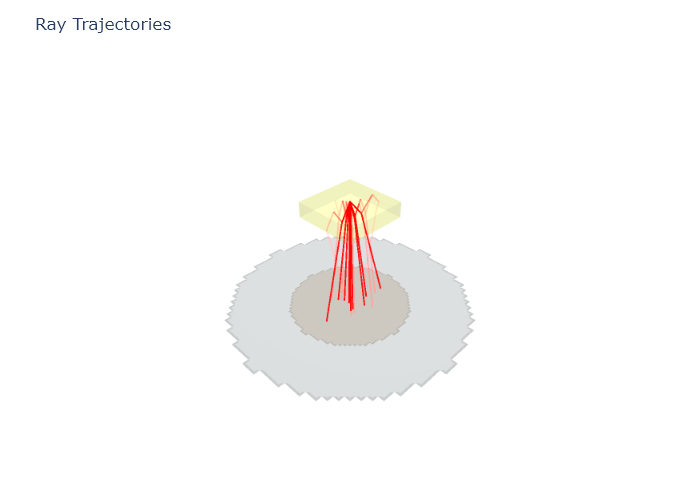

In [460]:

layout = PlotlyJS.Layout(
title="Ray Trajectories",
width=800,   # Set width in pixels
height=600,  # Set height in pixels
scene=attr(
    xaxis=attr(visible=false, showgrid=false, zeroline=false),
    yaxis=attr(visible=false, showgrid=false, zeroline=false),
    zaxis=attr(visible=false, showgrid=false, zeroline=false),
    bgcolor="rgba(255,255,255,1)", 
    aspectmode="data"
),
paper_bgcolor="rgba(255,255,255,1)", 
showlegend=false
)

# Display the plot
fig = PlotlyJS.plot(vcat(traces_objects, traces_trajectories), layout);
PlotlyJS.display(fig)

In [461]:
PlotlyJS.savefig(fig, "plot.html")  # Save as interactive HTML
run(`cmd /c start "plot.html"`)  # Windows

Process(`cmd /c start plot.html`, ProcessExited(0))

## Ray Hitting by Root Search


## Interface with Zeemax file